### CNN 기법을 이용한 물고기 품종 인식

In [1]:
# 글꼴 설치전 런타임 환경 확인
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

# GPU 런타임 환경 설정

# 보안 문제로 ipynb 파일 open시마다 실행
# from google.colab import drive
# drive.mount('/content/drive') # 마운트 이름은 자유롭게 지정 가능

In [2]:
%autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 

if (platform.system() == 'Windows'):  # Windows, Linux, Darwin
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    plt.rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/cnn/fish' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline  

Autosave disabled


In [46]:
width=128
height=80

# 훈련용 데이터 생성기
# rescale=1./255: 실수형태로 정규화, 0~1 사이의 값
train_datagen = ImageDataGenerator(rescale=1./255)
 
train_generator = train_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/train', # 파일이 있는 폴더, Colab은 절대 경로 명시해야 인식가능 
        './train', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(height, width), # 훈련데이터 크기
        batch_size=1,                # 이미지 1건씩 처리
        class_mode='categorical')    # 다중분류

# 검증용 데이터 생성기
vali_datagen = ImageDataGenerator(rescale=1./255)
 
vali_generator = vali_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/validation',
        './validation', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
# 3 classes: ./train/circle, ./train/rectangle, ./train/triangle

Found 24 images belonging to 4 classes.
Found 12 images belonging to 4 classes.


In [47]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (height, width,  3), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(30, activation='relu'))
# model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

cp = ModelCheckpoint(filepath='./Fish.h5', monitor='val_accuracy',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)

start = time.time()

hist = model.fit(
    train_generator,
    epochs=50,
    validation_data = vali_generator,
    callbacks=[cp, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))

# Total params: 118,282 Colab gpu: 42 ~ 83s, i5 2320: 58


# CPU: 
# Colab GPU: 26 초

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 80, 128, 32)       896       
                                                                 
 conv2d_5 (Conv2D)           (None, 80, 128, 32)       9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 40, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 81920)             0         
                                                                 
 dense_4 (Dense)             (None, 30)                2457630   
                                                                 
 dense_5 (Dense)             (None, 4)                 124       
                                                      

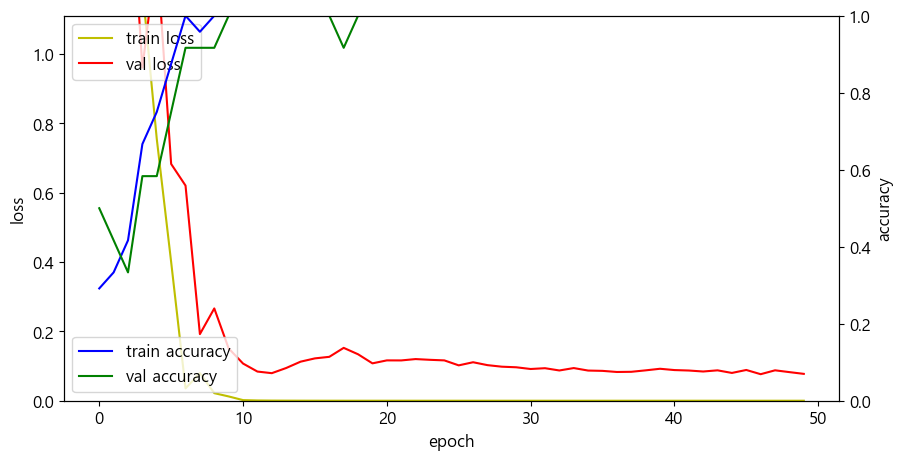

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline  

fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 1.1110]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch')  # 학습 횟수
loss_ax.set_ylabel('loss')   # 오차
acc_ax.set_ylabel('accuracy') # 정확도

loss_ax.legend(loc='upper left') # 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 정확도 레이블 위치

plt.show()

In [51]:
print("-- Evaluate --")
scores = model.evaluate_generator(vali_generator, verbose=0)  
print("%s: %.2f%%" %(model.metrics_names[1], scores[1]*100))

-- Evaluate --
accuracy: 100.00%


In [52]:
print("-- Predict --")
output = model.predict_generator(vali_generator)
# 실수를 소수점 3자리까지 출력 설정
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

# 그룹의 index {'circle': 0, 'rectangle': 1, 'triangle': 2}, 알파벳 순
print(vali_generator.class_indices) # 분류에 할당된 index
print(type(output))
print(output.shape) # 검증 이미지가 70개, 7개의 분류임으로 출력은 70행 7열
print(output)

-- Predict --
{'kwanga': 0, 'samchi': 1, 'shrimp': 2, 'wooruk': 3}
<class 'numpy.ndarray'>
(12, 4)
[[0.000 0.000 1.000 0.000]
 [0.000 0.744 0.012 0.244]
 [0.638 0.001 0.000 0.361]
 [1.000 0.000 0.000 0.000]
 [0.000 0.831 0.086 0.083]
 [0.000 0.000 1.000 0.000]
 [1.000 0.000 0.000 0.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.000 0.000 0.000 1.000]
 [0.000 1.000 0.000 0.000]
 [0.000 0.000 1.000 0.000]]


In [53]:
# model.save('/content/drive/My Drive/kd_ml/cnn/fish/Fish.h5')

In [54]:
# model = load_model('/content/drive/My Drive/kd_ml/cnn/fish/Fish.h5')
model = load_model('./Fish.h5')

In [74]:
# {'kwanga': 0, 'samchi': 1, 'wooruk': 2}
# def display(data):
#     # print(data)
#     # print(type(data))
#     sw= np.argmax(data)
#     # print('sw:', sw)

#     if sw == 0:
#         sw = '광어'
#     elif sw == 1:
#         sw = '삼치'
#     elif sw == 2:
#         sw = '우럭'
        
#     return sw    
# {'kwanga': 0, 'samchi': 1, 'wooruk': 2}
def display(data):
  if np.max(data) >= 0.5: # 확신이 있는 결과만 처리
    sw= np.argmax(data)

    if sw == 0:
        sw = '광어'
    elif sw == 1:
        sw = '삼치'
    elif sw == 2:
        sw = '새우'
    elif sw == 3:
        sw = '우럭'
    
  else:
    sw = '품종을 알수없습니다.'  
        
  return sw  

In [75]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/test1',
        './test1', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 광어 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.995 0.003 0.001 0.001]]
타겟: 광어 / 광어


In [76]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/test2',
        './test2', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 삼치 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.002 0.797 0.047 0.154]]
타겟: 삼치 / 삼치


In [77]:
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/test3',
        './test3', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(height, width),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 우럭 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.000 0.000 0.000 1.000]]
타겟: 우럭 / 우럭


In [78]:
# 훈련하지 않은 데이터 '쭈꾸미'의 사용
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/test4',
        './test4', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 쭈꾸미 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.


[[0.286 0.099 0.453 0.163]]
타겟: 쭈꾸미 / 품종을 알수없습니다.


In [79]:
# 훈련하지 않은 데이터 '쭈꾸미'의 사용
# 테스트용 데이터 생성기
test_datagen = ImageDataGenerator(rescale=1./255)
 
test_generator = test_datagen.flow_from_directory(
        # '/content/drive/My Drive/kd_ml/cnn/fish/test4',
        './test5', # 파일이 있는 폴더, Local은 상대 경로 명시
        target_size=(width, height),    
        batch_size=1,
        class_mode='categorical')
yp = model.predict_generator(test_generator)
print(yp)
print('타겟: 새우 /', display(yp))    # 2차원 텐서 전달

Found 1 images belonging to 1 classes.
[[0.146 0.221 0.518 0.115]]
타겟: 새우 / 새우


In [80]:
# {'kwanga': 0, 'samchi': 1, 'wooruk': 2}
def display_ext(data):
  if np.max(data) >= 0.5: # 확신이 있는 결과만 처리
    sw= np.argmax(data)

    if sw == 0:
        sw = '광어'
    elif sw == 1:
        sw = '삼치'
    elif sw == 2:
        sw = '우럭'
  else:
    sw = '품종을 알수없습니다.'  
        
  return sw  

In [81]:
print(yp)
print(np.max(yp))
print('타겟: 쭈꾸미 /', display_ext(yp))    # 2차원 텐서 전달    

[[0.146 0.221 0.518 0.115]]
0.51766133
타겟: 쭈꾸미 / 우럭
